## 0. introduction and setup

In [1]:
# sepiatone:2024-05
# notebook for creating a model to classify paintings according to their art syle
# wikiart dataset, prepared from https://www.wikiart.org/ by saleh-2015-classification_fine_art_paintings (https://arxiv.org/pdf/1505.00855)

# setup so that the notebook can be run from kaggle / colab / local machine (tip from howard / fast.ai)
# note that data for a kaggle competition always lives in the ../input folder
import os
from pathlib import Path

is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if is_kaggle:
    path_input = Path('../input/wikiart')
else:
    path_input = Path('wikiart')
    import zipfile, kaggle
    kaggle.api.competition.download_cli(str(path_input))
    zipfile.ZipFile(f'{path}.zip').extractall(path_input)
    
# test
# for dirname, _, filenames in os.walk(path_input):
#    print(f'{dirname}')

In [2]:
! pip install -Uqq fastbook

In [3]:
import shutil

from PIL import Image
from fastbook import get_image_files, DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label, RandomResizedCrop, aug_transforms
from fastbook import vision_learner, resnet18, error_rate, ClassificationInterpretation, Resize

## 1. prepare the data

In [4]:
# copy some art styles to the `/kaggle/working/` folder. 
art_styles = ["Pop_Art", "Cubism", "Baroque", "Art_Nouveau_Modern"]
path_working = Path("/kaggle/working/")

for art_style in art_styles:
    shutil.rmtree(os.path.join(path_working, art_style), ignore_errors = True)

for art_style in art_styles:
    images = os.listdir(os.path.join(path_input, art_style))
    try:
        os.mkdir(os.path.join(path_working, art_style))
    except OSError as error:
        print(error)
    for image in images:
        shutil.copy(os.path.join(path_input, art_style + '/') + image, os.path.join(path_working, art_style + '/') + image)

In [5]:
images = get_image_files(path_working)

# test
len(images)

12292

## 2. build the `DataBlock`

#### 2a. `Datablock` with the transformations - resizing the images to 224*224 alongwith data augmentation and a random crop 

In [6]:
paintings = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms = aug_transforms())

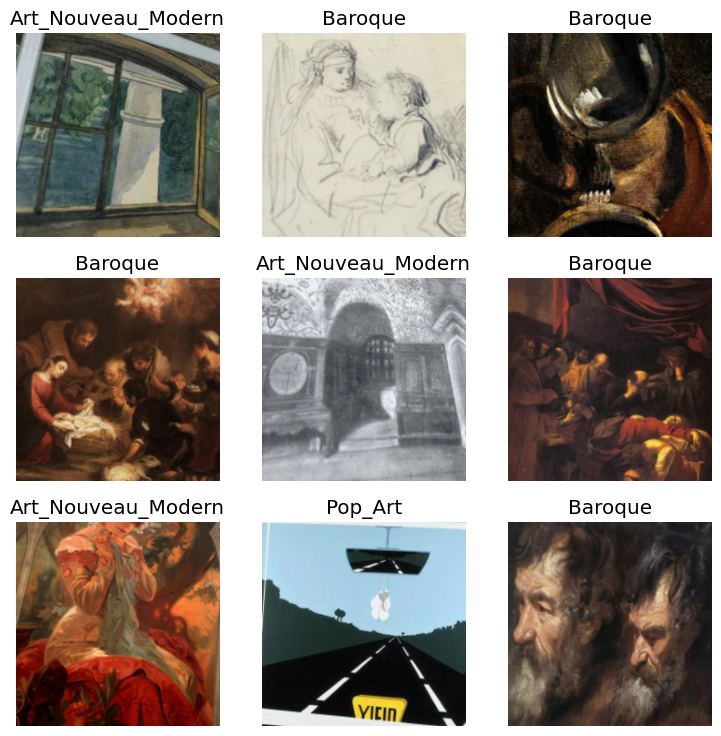

In [7]:
dls = paintings.dataloaders(path_working)

# test
dls.show_batch()

## 3. train the model

#### set the training parameters and train the model

In [8]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.871567,0.634460,0.214402,02:39


epoch,train_loss,valid_loss,error_rate,time
0,0.505784,0.397087,0.144020,02:39
1,0.357577,0.341602,0.123271,02:40


## 4. Visualization

### 4a. confusion matrix for the model

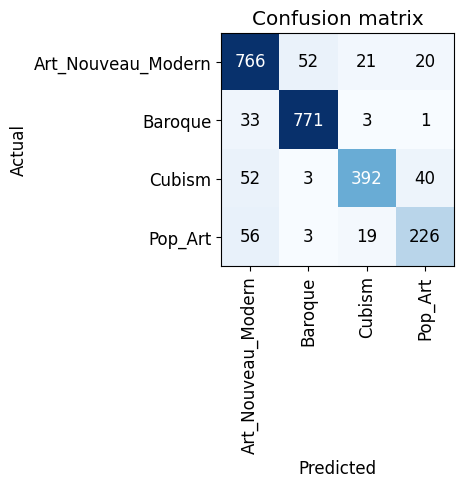

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

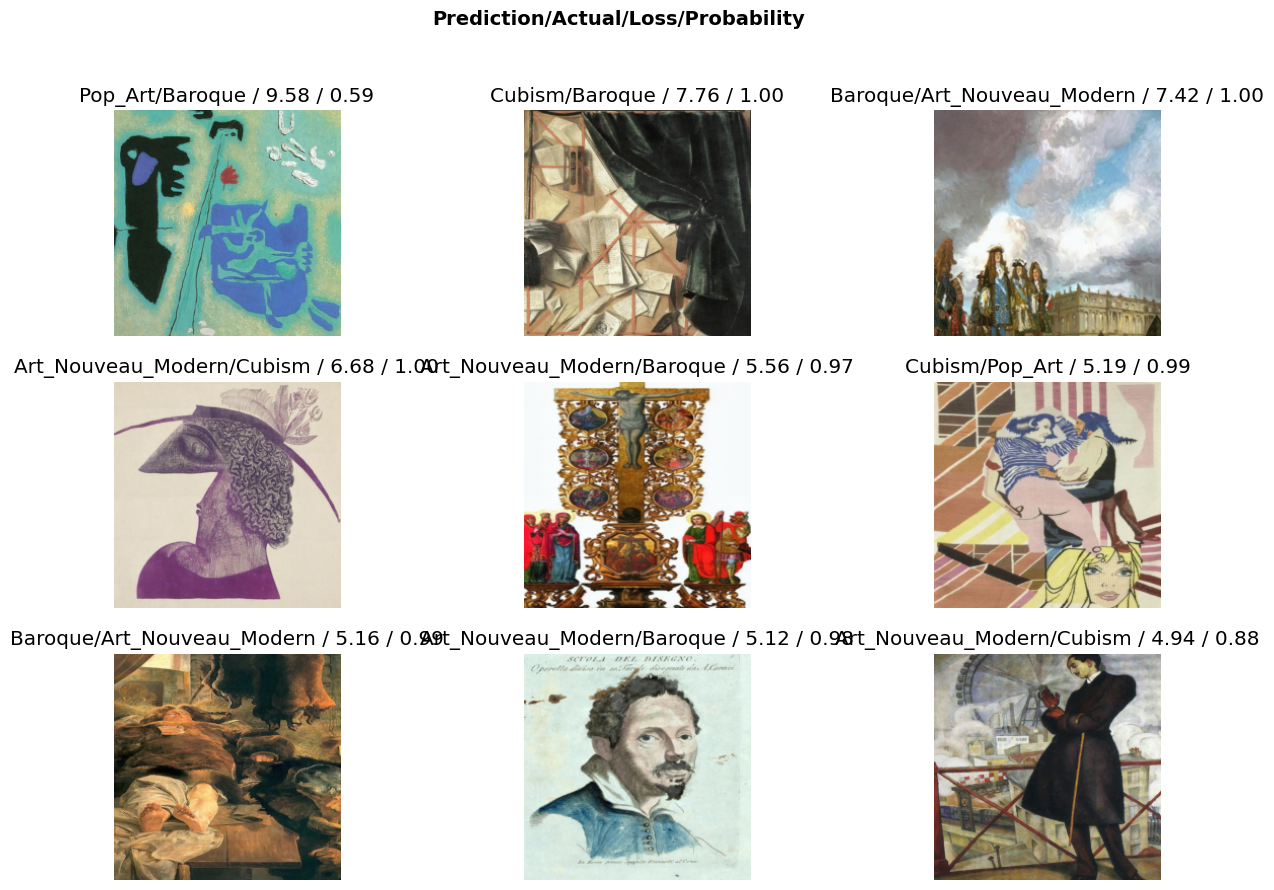

In [10]:
interp.plot_top_losses(9, figsize=(15,10))

## 5. Classification

### Show the probabilities of an image being of each art movement type

In [11]:
import mimetypes

path_test = Path("../input/test-2")

for _, _, filenames in os.walk(path_test):
    for filename in filenames:
        print(f'file: {filename}, type of file: {mimetypes.guess_type(filename)}')
        
        _, _, predictions = learn.predict("".join([str(path_test), '/', str(filename)]))
  
        print(f'* this how confident the model is for each label: ')
        for index, label in enumerate(dls.vocab):
            print(f"    {label}:\t{predictions[index]:.3%}")

file: pop_art-lichtenstein-drowning_girl.jpg, type of file: ('image/jpeg', None)


* this how confident the model is for each label: 
    Art_Nouveau_Modern:	14.793%
    Baroque:	0.016%
    Cubism:	8.114%
    Pop_Art:	77.077%
file: cubist-picasso-girl_with_mandolin.jpg, type of file: ('image/jpeg', None)


* this how confident the model is for each label: 
    Art_Nouveau_Modern:	0.000%
    Baroque:	0.000%
    Cubism:	99.998%
    Pop_Art:	0.001%
